In [2]:
import json
import os

import sys
import socket
import cv2
import numpy as np
import base64

import torch
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.refcoco import RefcocoTask
from models.ofa import OFAModel
from PIL import Image
import argparse
from torchvision import transforms
import json

os.environ["CUDA_VISIBLE_DEVICES"]="3,4"

# Load OFA

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="3,4"

tasks.register_task('refcoco', RefcocoTask)
use_cuda = torch.cuda.is_available()
overrides={"bpe_dir":"/home/jhkim/icra24/OFA/utils/BPE"}

ofa_path = '/data/jhkim/iros23/OFA_checkpoints/refcoco_large_best.pt'
ofa_gvcci_path = '/data/jhkim/iros23/OFA_refcoco_checkpoints_0208_pick/0208_train_135/checkpoint_last.pt'

models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(ofa_gvcci_path),
        arg_overrides=overrides
    )

cfg.common.seed = 7
cfg.generation.beam = 5
cfg.generation.min_len = 4
cfg.generation.max_len_a = 0
cfg.generation.max_len_b = 4
cfg.generation.no_repeat_ngram_size = 3

# Fix seed for stochastic decoding
if cfg.common.seed is not None and not cfg.generation.no_seed_provided:
    np.random.seed(cfg.common.seed)
    utils.set_torch_seed(cfg.common.seed)

# Move models to GPU
for model in models:
    model.eval()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text.lower()),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for refcoco task
patch_image_size = cfg.task.patch_image_size
def construct_sample(image: Image, text: str):
    w, h = image.size
    w_resize_ratio = torch.tensor(patch_image_size / w).unsqueeze(0)
    h_resize_ratio = torch.tensor(patch_image_size / h).unsqueeze(0)
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(' which region does the text " {} " describe?'.format(text), append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "w_resize_ratios": w_resize_ratio,
        "h_resize_ratios": h_resize_ratio,
        "region_coords": torch.randn(1, 4)
    }
    return sample

2023-08-13 13:27:27 | INFO | tasks.ofa_task | source dictionary: 59457 types
2023-08-13 13:27:27 | INFO | tasks.ofa_task | target dictionary: 59457 types
/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
/home/jhkim/anaconda3/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Construct Data
## for label propagation

### Save cropped images
### Save labels json

- json
- {obj1: {obj1_0: [], obj1_1: [], ...}, ...}

In [5]:
import pandas as pd

json_path = '../interactive/'
save_json_path = '/home/jhkim/icra24/interactive/interactive_perQ_bbox.json' #{'0.png':[perQ, bbox], ...}
cropped_img_path = '/data/jhkim/icra24/cropped_interaction/'
raw_img_path = '/data/jhkim/icra24/raw_images/interaction/'

object_num = 96

#### make total interactive annotation dictionary
annotation = {}
for i in range(object_num):
    with open(os.path.join(json_path,'interactive{}.json'.format(i)), 'r') as f:
        annotation_each = json.load(f)    # annotation_each -> {'0': ['dark brown tube in front', 'a nourishing hand cream']}
    for k,v in annotation_each.items():
        if int(k) == i:
            annotation[k] = v

#### check if all personal annotations are correct
## Read Excel
xcel_path = '/home/jhkim/icra24/test.xlsx'
xl = pd.ExcelFile(xcel_path)
df = xl.parse(xl.sheet_names[0])
df = df.fillna("")
all_annotations = []
for index, row in df.iterrows():
    if type(row[0]) == float: #confirm that this is a valid object
        all_annotations.append(row[3].strip())  # NL query

## check if all the interaction personal indicators are in the labelling
for k,v in annotation.items():
    if v[1] not in all_annotations:
        print("Wrong!! object {} // interaction::: {}".format(k,v[1]))    

### manually correct the indicator from interaction

In [15]:
#####
import numpy

data_save = {}
for obj in os.listdir(raw_img_path): # obj: 0.png, 0_0.png, ...

    obj_id = obj.split('.')[0].split('_')[0]
    ofa_in = annotation[obj_id][0] + ' on the gripper'
    personal_q = annotation[obj_id][1]
    
    image = Image.open(os.path.join(raw_img_path, obj))
    x_crop, y_crop = 100, 180
    image_crop = image.crop((x_crop,y_crop,image.size[0],image.size[1]))
    text = ofa_in
    sample = construct_sample(image_crop, text)
    sample = utils.move_to_cuda(sample) if use_cuda else sample
    with torch.no_grad():
        result, scores = eval_step(task, generator, models, sample)
    bbox = result[0]["box"]#.tolist()
    bbox[1] += y_crop
    bbox[3] += y_crop
    bbox[0] += x_crop
    bbox[2] += x_crop

    try:
        data_save[obj] = [personal_q, bbox]
        # save cropped image
        crop_path = os.path.join(cropped_img_path, obj)
        image = np.asarray(image)
        cropped = image[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
        cropped = Image.fromarray(cropped)
        cropped.save(crop_path)
    except:
        print("bbox out of range!!! --object: {} --ofa_in: {}".format(obj, ofa_in))

with open(save_json_path, 'w') as f:
    json.dump(data_save, f)

bbox out of range!!! --object: 25_8.png --personalQ: my Nivea lip balm
bbox out of range!!! --object: 2.png --personalQ: the remote for air conditioner
bbox out of range!!! --object: 0_7.png --personalQ: a nourishing hand cream
bbox out of range!!! --object: 44.png --personalQ: a caffeine free coffee
bbox out of range!!! --object: 46.png --personalQ: my brother's glasses case
bbox out of range!!! --object: 54.png --personalQ: my dog Andy's best-loved toy
bbox out of range!!! --object: 7.png --personalQ: the strongest duct tape
bbox out of range!!! --object: 25_4.png --personalQ: my Nivea lip balm
bbox out of range!!! --object: 10_3.png --personalQ: my Iron Man pencil case
bbox out of range!!! --object: 78.png --personalQ: grapes


# Manually Re-do OFA inference ?

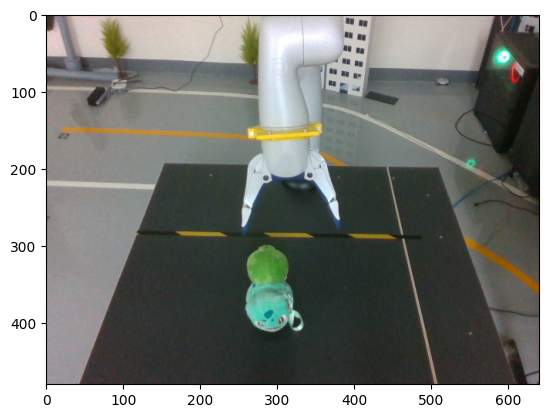

In [86]:
obj_id = '93'

import cv2
import numpy

img = Image.open('/data/jhkim/icra24/raw_images/interaction/{}.png'.format(obj_id))

from matplotlib import pyplot as plt

plt.imshow(img)

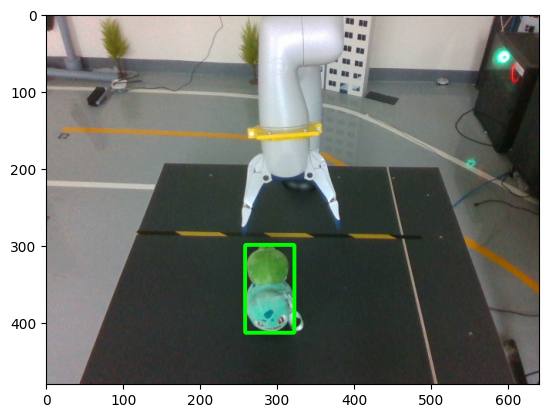

In [87]:
ofa_in = 'green object in front'
image = Image.open('/data/jhkim/icra24/raw_images/interaction/{}.png'.format(obj_id))
y_crop = 200
image_crop = image.crop((0,y_crop,image.size[0],image.size[1]))

text = ofa_in
sample = construct_sample(image_crop, text)
sample = utils.move_to_cuda(sample) if use_cuda else sample
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)
bbox = result[0]["box"]#.tolist()
bbox[1] += y_crop
bbox[3] += y_crop

img = cv2.cvtColor(numpy.asarray(image), cv2.COLOR_RGB2BGR)
cv2.rectangle(
    img,
    (int(result[0]["box"][0]), int(result[0]["box"][1])),
    (int(result[0]["box"][2]), int(result[0]["box"][3])),
    (0, 255, 0),
    3
)
#print(result[0]["box"])

#cv2.imshow("testing", img)
from matplotlib import pyplot as plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Save revised object bbox data

In [88]:
save_json_path = '/home/jhkim/icra24/interactive/interactive_perQ_bbox.json' #{'0.png':[perQ, bbox], ...}
cropped_img_path = '/data/jhkim/icra24/cropped_interaction/'
image = Image.open('/data/jhkim/icra24/raw_images/interaction/{}.png'.format(obj_id))

with open(save_json_path, 'r') as f:
    data = json.load(f)
    data[obj_id+'.png'][1] = bbox

with open(save_json_path, 'w') as f:
    json.dump(data, f)


crop_path = os.path.join(cropped_img_path, obj_id+'.png')
image = np.asarray(image)
cropped = image[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
cropped = Image.fromarray(cropped)
cropped.save(crop_path)

In [24]:
bbox

[246.6466522216797, 357.5175018310547, 322.88287353515625, 444.40440368652344]